# Load data

"spider\train_spider.json"

In [1]:
import pandas as pd
import warnings


warnings.filterwarnings('ignore')

class Train_Data():
    
    '''
    Train_Data class Loads the data from multiple Training JSON files in Pandas Dataframes
    '''
   
    def __init__(self, path , filenames):
        '''
            Parameters
            ------------
            path: directory where English to SQL translation JSON are placed
            filenames: Json file names containing Train data
        '''
        self.path = path
        self.filenames = filenames
        self.df_train = pd.DataFrame()
        for f in self.filenames:
            print("Reading file at path", self.path+f)
            try:
                df = pd.read_json(self.path + f)
                if len(self.df_train) == 0:
                    self.df_train = df
                else:
                    self.df_train = self.df_train.append(df)
                print("{} Rows in Total".format(len(self.df_train)))
            except Exception as e:
                print("Got error while Reading file : " , e)
                
    @property          
    def questions(self):
        ''' 
        Returns
        ------------
        Returns English Questions in Dataframe Rows as List
        '''
        return self.df_train.question.values.tolist()
    
    @property
    def sql(self):
        '''
        Returns
        ------------
        Returns SQL in Dataframe Rows as List
        '''
        return self.df_train['query'].values.tolist()
    
    @property          
    def question_tokens(self):
        ''' 
        Returns
        ------------
        Returns English Question Tokens in Dataframe Rows as List
        '''
        
        return self.df_train['question_toks'].values.tolist()
    
    @property
    def sql_tokens(self):
        ''' 
        Returns
        ------------
        Returns SQL Query Tokens in Dataframe Rows as List
        '''
        return self.df_train['query_toks'].values.tolist()
    
    def get_special_characters(self,list_of_text):
        '''
        Parameters
        ------------
        list_of_text: Input List of Text 
        Returns
        ------------
        Provides list of Special Characters in the text
        '''
        return list(set(Preprocess.special_char(''.join([''.join(ele) for ele in list_of_text]))))
    
    def get_vocab_size(self, list_of_text):
        """
        Parameters
        ------------
        list_of_text: Input List of Text 
        
        Returns
        ------------
        Vocabulary size or unique words in the corpus
        """
        word_list = []
        for sentence in list_of_text:
            for word in sentence.split():
                word = word.lower().strip()
                if word not in word_list:
                    word_list.append(word)
        return len(word_list), word_list
        
    
    
    
    
    
    
#################################
#CONSTANTS

EOS = '[END]'
SOS = '[START]'  
    
    
    
    
    
#################################################################################################################
    
import re
import tensorflow as tf
import tensorflow_text as tf_text

class Preprocess():
    def __init__(self,text):
        """
            Parameters
            ------------
            text : Input string
            Runs the text processing steps
            
        """
        self.processed_text = self.run_pipeline(text)
    
    def text_standardize(self, text):
        """
            Parameters
            ------------
            text : Input string
            
            Returns
            ------------
            -   Unicode normalization using NFKD method
            -   Lower Case text
        
        """
        text = tf_text.normalize_utf8(text, 'NFKD')
        text = tf.strings.lower(text)
        return text
    
    def text_whitespace(self, text):
        """
            Parameters
            ------------
            text : Input string
            
            Returns
            ------------
            -   Remove $ and \\ special characters 
            -   Add space around punctations
            -   Remove spaces around sentences
        
        """
        text = tf.strings.regex_replace(text, '[$\\\\]', '')
        text = tf.strings.regex_replace(text, '[.?!,¿()*:@]', r' \0 ')
        text = tf.strings.strip(text)
        return text
    
    def add_SOS_EOS(self, text):
        """
            Parameters
            ------------
            text : Input string
            
            Returns
            ------------
            -   Add <SOS> and <EOS> tags to each sentence
        
        """
        text = tf.strings.join([SOS, text, EOS], separator=' ')
        return text
    
    @classmethod
    def special_char(cls, text):
        """
            Parameters
            ------------
            text : Input string
            
            Returns
            ------------
            -   Special Characters found in Text using Regular Expression
        """
        return re.findall(r'[\W]',text.replace(' ',''))
    
    
    def run_pipeline(self,text):
        """
            Parameters
            ------------
            text : Input string
            
            Returns
            ------------
            Executes series of Text pre processing functions
        
        """
        text = self.text_standardize(text)
        text = self.text_whitespace(text)
        text = self.add_SOS_EOS(text)
        self.text = text
        return self.text
        

In [3]:
try:
    del(o)
except:
    pass
o = Train_Data('D:/DS/Learnin/Essex MS/CE888/CE888/assignment/seq2seq/spider/',['train_spider.json','train_others.json'])

Reading file at path D:/DS/Learnin/Essex MS/CE888/CE888/assignment/seq2seq/spider/train_spider.json
7000 Rows in Total
Reading file at path D:/DS/Learnin/Essex MS/CE888/CE888/assignment/seq2seq/spider/train_others.json
8659 Rows in Total


In [4]:
o.sql[0]

'SELECT count(*) FROM head WHERE age  >  56'

In [5]:
Preprocess(o.sql[0]).processed_text.numpy().decode()

'[START] select count (  *  )  from head where age  >  56 [END]'

In [6]:
# o.get_special_characters(o.sql)
# o.get_special_characters(o.questions)
# o.get_vocab_size(o.questions)
_,w = o.get_vocab_size(o.questions)

In [7]:
# ''.join([''.join(ele) for ele in o.questions])

In [8]:
def tf_lower_and_split_punct(text):
    return Preprocess(text).processed_text

In [9]:
max_vocab_size = 7000

input_text_processor = tf.keras.layers.TextVectorization( standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size)
input_text_processor.adapt(o.questions)
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'the', '[START]', '[END]', 'of', '?', '.', 'what', 'are']

In [10]:
output_text_processor = tf.keras.layers.TextVectorization(    standardize=tf_lower_and_split_punct,    max_tokens=max_vocab_size)

output_text_processor.adapt(o.sql)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '.', 't1', 't2', '=', 'select', 'from', 'as', '[START]']

In [11]:
input_text_processor.vocabulary_size()

3955

In [12]:
inp = o.questions
targ = o.sql

In [13]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [15]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'Find the name of projects that require between 100 and 300 hours of work.'
 b'Count the number of stores the chain South has.'
 b'Who cites Daniel A Reed the most'
 b'What are the course codes for every class that the student with the last name Smithson took?'
 b'Show the top 3 most common colleges of players in match seasons.'], shape=(5,), dtype=string)

tf.Tensor(
[b'SELECT name FROM projects WHERE hours BETWEEN 100 AND 300'
 b'SELECT count(*) FROM department_stores AS T1 JOIN department_store_chain AS T2 ON T1.dept_store_chain_id  =  T2.dept_store_chain_id WHERE T2.dept_store_chain_name  =  "South"'
 b'SELECT DISTINCT COUNT ( t4.citingpaperid )  ,  t3.authorid FROM writes AS t2 JOIN author AS t1 ON t2.authorid  =  t1.authorid JOIN cite AS t4 ON t2.paperid  =  t4.citedpaperid JOIN writes AS t3 ON t3.paperid  =  t4.citingpaperid WHERE t1.authorname  =  "Daniel A Reed" GROUP BY t3.authorid ORDER BY COUNT ( t4.citingpaperid ) DESC;'
 b"SELECT T1.crs_code FROM CLASS AS T1 

In [22]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :]

<tf.Tensor: shape=(3, 28), dtype=int64, numpy=
array([[   3,   20,    2,   14,    5,  277,   17, 1587,  172,  210,   10,
         551,  179,    5,  507,    7,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   3,   59,    2,   18,    5,  600,    2, 2578, 1570,   34,    7,
           4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   3,   24, 2565, 1100,   33, 2198,    2,   30,    4,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int64)>

In [17]:
import numpy as np
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] find the name of projects that require between 100 and 300 hours of work . [END]           '

Text(0.5, 1.0, 'Mask')

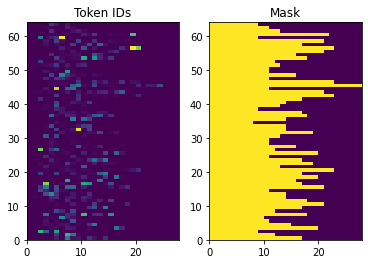

In [18]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [19]:
embedding_dim = 256
units = 1024

In [20]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                    # Return the sequence and state
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        


        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)


        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)


        # 4. Returns the new sequence and its state.
        return output, state

In [21]:
input_text_processor.vocabulary_size()

3955

In [404]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 29)
Encoder output, shape (batch, s, units): (64, 29, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [405]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
       
        # From Eqn. (4), `W1@ht`.
        w1_query = self.W1(query)
       
        # From Eqn. (4), `W2@hs`.
        w2_key = self.W2(value)

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores = True,
        )

        return context_vector, attention_weights

In [406]:
attention_layer = BahdanauAttention(units)

In [407]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 29)


Text(0.5, 1.0, 'Mask')

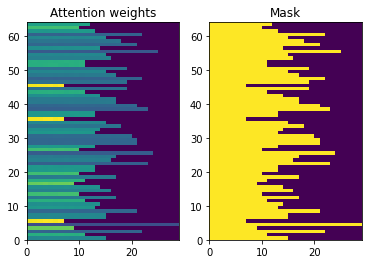

In [408]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [409]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

In [410]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [414]:
import typing
from typing import Any, Tuple

class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [415]:
def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
 

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)

  return DecoderOutput(logits, attention_weights), state

In [416]:
Decoder.call = call

In [417]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [418]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [419]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 3821)
state shape: (batch_size, dec_units) (64, 1024)


In [420]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [421]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['"%gmail'],
       ['milliseconds'],
       ["'%senior%'"],
       ['"fahey"'],
       ['"spring"']], dtype='<U38')

In [422]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [423]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['"ashley"'],
       ['gymnast'],
       ["swift'"],
       ['"tom'],
       ["'hartford'"]], dtype='<U38')

In [424]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

In [425]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                        embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                        embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function

    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
         return self._train_step(inputs)

In [446]:
def _preprocess(self, input_text, target_text):
  

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  

  # Convert IDs to masks.
  input_mask = input_tokens != 0
 

  target_mask = target_tokens != 0
  

  return input_tokens, input_mask, target_tokens, target_mask

In [447]:
TrainTranslator._preprocess = _preprocess

In [448]:
def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = tf.shape(target_tokens)[1]

    with tf.GradientTape() as tape:
        # Encode the input
        enc_output, enc_state = self.encoder(input_tokens)
        

        # Initialize the decoder's state to the encoder's final state.
        # This only works if the encoder and decoder have the same number of
        # units.
        dec_state = enc_state
        loss = tf.constant(0.0)

        for t in tf.range(max_target_length-1):
            # Pass in two tokens from the target sequence:
            # 1. The current input to the decoder.
            # 2. The target for the decoder's next prediction.
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                    enc_output, dec_state)
            loss = loss + step_loss

    # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

In [449]:
TrainTranslator._train_step = _train_step

In [450]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                enc_output=enc_output,
                                mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)


    # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state

In [451]:
TrainTranslator._loop_step = _loop_step

In [452]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [453]:
np.log(output_text_processor.vocabulary_size())

8.2482674474469

In [454]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.951701>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.9168835>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.8477216>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6239653>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.3947244>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.1367636>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.033578>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.570592>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.483702>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4609165>}

Wall time: 2min 39s


In [455]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [456]:
TrainTranslator._tf_train_step = _tf_train_step


In [457]:
translator.use_tf_function = True


In [458]:
translator.train_step([example_input_batch, example_target_batch])


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4187317>}

In [459]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3186517>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2358704>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1614246>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0734386>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.013017>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.000471>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.011034>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0147676>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.003209>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9806223>}

Wall time: 1min 38s


....................................................................................................


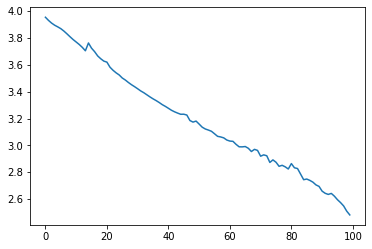

In [462]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [464]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [465]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [466]:
train_translator.fit(dataset, epochs=3, callbacks=[batch_loss])

Epoch 1/3
136/136 [==============================] - 1041s 8s/step - batch_loss: 3.3776
Epoch 2/3
136/136 [==============================] - 988s 7s/step - batch_loss: 1.5859
Epoch 3/3
136/136 [==============================] - 986s 7s/step - batch_loss: 1.1937


Text(0, 0.5, 'CE/token')

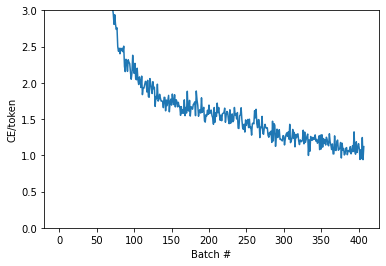

In [467]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [468]:
class Translator(tf.Module):
    
  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [469]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [470]:
def tokens_to_text(self, result_tokens):
    
    result_text_tokens = self.output_token_string_from_index(result_tokens)
   

    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')
    

    result_text = tf.strings.strip(result_text)
    
    return result_text

In [471]:
Translator.tokens_to_text = tokens_to_text

In [472]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'"lake candidate', b'"alfred 3000', b'\'clerical "chrissy"',
       b'example srivastava";', b'cascade"; 2010;'], dtype=object)

In [473]:
def sample(self, logits, temperature):

    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

    # Set the logits for all masked tokens to -inf, so they are never chosen.
    logits = tf.where(self.token_mask, -np.inf, logits)

    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else: 
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits/temperature,
                                            num_samples=1)

    return new_tokens

Translator.sample = sample


In [474]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 322],
       [1653],
       [2475],
       [1143],
       [2442]], dtype=int64)>

In [475]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [476]:
Translator.translate = translate_unrolled

In [477]:
%%time
input_text = tf.constant([
    'How many singers do we have?', # "It's really cold here."
    'What is the total number of singers?', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

select distinct count ( t1 . spent ) from location as t1 join district as t2 on t1 . mountain_id = t2 . people_id
select count ( * ) from class

Wall time: 503 ms
